# 🌊 VELA Eco-Crypto Analysis 
This notebook explores the intersection of **cryptocurrency** and **climate change** data.  
The goal is to highlight how blockchain-based projects like **VELA** can align with environmental trends and support ocean conservation efforts.

**Objectives:**
- Import and prepare datasets (crypto + CO₂ emissions).
- Explore trends and correlations.
- Build visuals that communicate the environmental case for VELA.
- Draft insights for public sharing.


In [12]:
# Cell 1: Imports & setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr
import yfinance as yf
from scipy import stats

# Set plotting style
plt.style.use("seaborn-v0_8-whitegrid")



This notebook integrates environmental and crypto datasets. We’ll combine NOAA CO₂, NASA-style global temperature anomalies, and BTC/ETH crypto market data. The goal is to explore correlations, test hypotheses, and prepare insights for the VELA eco-token project.

In [13]:
# Cell 2: Load CO₂ and Temp

co2_path = r"C:\Users\rcolo\Downloads\co2_mm_mlo.csv"
temp_path = r"C:\Users\rcolo\Downloads\air.2x2.250.mon.anom.comb.nc"

# Load CO₂
co2 = pd.read_csv(co2_path, comment="#").rename(columns=str.lower)

# Create datetime column
co2["date"] = pd.to_datetime(dict(year=co2["year"], month=co2["month"], day=1))

# Prefer interpolated column if it exists, else use average
if "interpolated" in co2.columns:
    co2_val_col = "interpolated"
elif "average" in co2.columns:
    co2_val_col = "average"
elif "trend" in co2.columns:
    co2_val_col = "trend"
else:
    raise KeyError("No suitable CO₂ column found in file.")

co2 = co2[["date", co2_val_col]].rename(columns={co2_val_col:"co2_ppm"})
co2 = co2.set_index("date").sort_index()

# Load Temps (NetCDF)
import xarray as xr
ds = xr.open_dataset(temp_path)
temps = ds["air"].mean(dim=["lat","lon"]).to_dataframe().reset_index()
temps = temps[["time","air"]].rename(columns={"time":"date","air":"temp_anomaly_c"})
temps = temps.set_index("date").sort_index()

# --- Merge ---
env = co2.join(temps, how="inner").dropna()
env.head(10)


,co2_ppm,temp_anomaly_c
date,,
1958-03-01,315.71,0.053415
1958-04-01,317.45,-0.373661
1958-05-01,317.51,0.017461
1958-06-01,317.27,-0.244230
1958-07-01,315.87,0.351428
1958-08-01,314.93,-0.103971
1958-09-01,313.21,0.153030
1958-10-01,312.42,0.112136
1958-11-01,313.33,-0.080243


We now have a monthly time series of atmospheric CO₂ (ppm) and global average temperature anomalies (°C). These serve as the backbone of the environmental dataset.

c:\Users\rcolo\OneDrive\Desktop\vela-eco-crypto\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


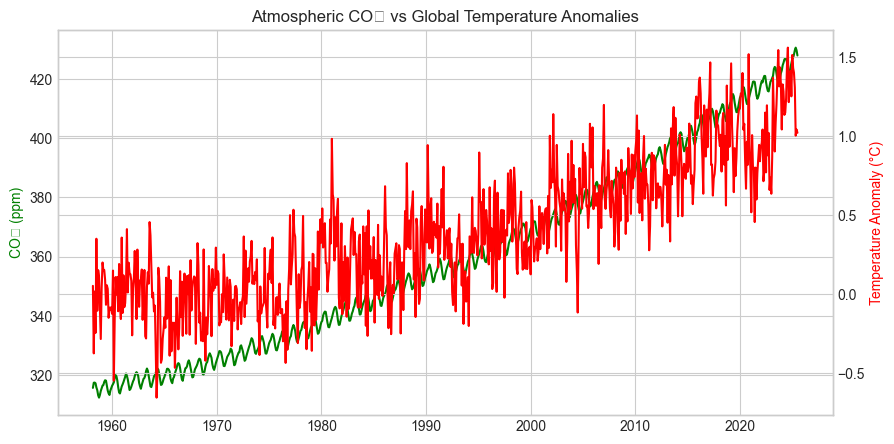

In [14]:
# Cell 3: Visualize environmental trends

fig, ax1 = plt.subplots(figsize=(10,5))
ax1.plot(env.index, env["co2_ppm"], color="green", label="CO₂ (ppm)")
ax1.set_ylabel("CO₂ (ppm)", color="green")

ax2 = ax1.twinx()
ax2.plot(env.index, env["temp_anomaly_c"], color="red", label="Temp Anomaly (°C)")
ax2.set_ylabel("Temperature Anomaly (°C)", color="red")

plt.title("Atmospheric CO₂ vs Global Temperature Anomalies")
plt.show()


The plot shows the well-established trend: as atmospheric CO₂ rises, global temperatures follow. This provides context for VELA’s environmental mission.

In [15]:
# Cell 4: Load crypto datasets (BTC & ETH)

# Pull daily BTC and ETH data using yfinance, starting from 2015 (BTC) and 2016 (ETH).

btc = yf.download("BTC-USD", start="2015-01-01", interval="1d")[["Close","Volume"]]
eth = yf.download("ETH-USD", start="2016-01-01", interval="1d")[["Close","Volume"]]

btc.columns = ["price","volume"]
eth.columns = ["price","volume"]

btc.index = btc.index.tz_localize(None)
eth.index = eth.index.tz_localize(None)

btc.head(10)


C:\Users\rcolo\AppData\Local\Temp\ipykernel_20960\3080305458.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  btc = yf.download("BTC-USD", start="2015-01-01", interval="1d")[["Close","Volume"]]
[*********************100%***********************]  1 of 1 completed
C:\Users\rcolo\AppData\Local\Temp\ipykernel_20960\3080305458.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  eth = yf.download("ETH-USD", start="2016-01-01", interval="1d")[["Close","Volume"]]
[*********************100%***********************]  1 of 1 completed


,price,volume
Date,,
2015-01-01,314.248993,8036550
2015-01-02,315.032013,7860650
2015-01-03,281.082001,33054400
2015-01-04,264.195007,55629100
2015-01-05,274.473999,43962800
2015-01-06,286.188995,23245700
2015-01-07,294.337006,24866800
2015-01-08,283.348999,19982500
2015-01-09,290.407990,18718600


We now have daily BTC and ETH prices and volumes. This will allow us to engineer volatility features and align with environmental data.

In [16]:
# Cell 5: Feature engineering for crypto

def add_features(df, prefix):
    out = df.copy()
    out[f"{prefix}_ret"] = out["price"].pct_change()
    out[f"{prefix}_absret"] = out[f"{prefix}_ret"].abs()
    out[f"{prefix}_roll_vol_14"] = out[f"{prefix}_ret"].rolling(14, min_periods=7).std()
    out[f"{prefix}_roll_vol_30"] = out[f"{prefix}_ret"].rolling(30, min_periods=10).std()
    out[f"{prefix}_roll_ret_7"]  = out[f"{prefix}_ret"].rolling(7, min_periods=4).mean()
    out[f"{prefix}_vol_chg"]     = out["volume"].pct_change()
    return out

btc_f = add_features(btc, "btc")
eth_f = add_features(eth, "eth")

btc_f.tail(10)


,price,volume,btc_ret,btc_absret,btc_roll_vol_14,btc_roll_vol_30,btc_roll_ret_7,btc_vol_chg
Date,,,,,,,,
2025-09-16,116843.187500,45781744593,0.012112,0.012112,0.008576,0.016193,0.006708,-0.135180
2025-09-17,116468.507812,60528025996,-0.003207,0.003207,0.008755,0.016092,0.003144,0.322100
2025-09-18,117137.203125,49457272032,0.005741,0.005741,0.008064,0.015111,0.002019,-0.182903
2025-09-19,115688.859375,38828473971,-0.012365,0.012365,0.009128,0.015153,-0.000483,-0.214909
2025-09-20,115721.960938,22864449614,0.000286,0.000286,0.008946,0.014819,-0.000256,-0.411142
2025-09-21,115306.093750,22495852193,-0.003594,0.003594,0.009009,0.012921,-0.000100,-0.016121
2025-09-22,112748.507812,70684158591,-0.022181,0.022181,0.011011,0.013338,-0.003315,2.142097
2025-09-23,112014.500000,47211853279,-0.006510,0.006510,0.011083,0.013046,-0.005975,-0.332073
2025-09-24,113328.632812,48044595085,0.011732,0.011732,0.009852,0.012008,-0.003841,0.017638


We engineered returns, rolling volatility, rolling returns, and volume change. These will help us capture crypto’s volatility regimes, which are important for tokenomics.

In [17]:
# Cell 6: Resample to monthly and align

def to_monthly(df, prefix):
    m = pd.DataFrame({
        f"{prefix}_price":      df["price"].resample("MS").last(),
        f"{prefix}_volume":     df["volume"].resample("MS").sum(),
        f"{prefix}_roll_vol_14":df[f"{prefix}_roll_vol_14"].resample("MS").last(),
        f"{prefix}_roll_vol_30":df[f"{prefix}_roll_vol_30"].resample("MS").last(),
        f"{prefix}_roll_ret_7": df[f"{prefix}_roll_ret_7"].resample("MS").mean(),
        f"{prefix}_absret":     df[f"{prefix}_absret"].resample("MS").mean(),
        f"{prefix}_vol_chg":    df[f"{prefix}_vol_chg"].resample("MS").mean(),
    })
    return m

btc_m = to_monthly(btc_f, "btc")
eth_m = to_monthly(eth_f, "eth")

monthly = env.join(btc_m, how="inner").join(eth_m, how="inner").dropna(how="all")
monthly.head(10)


,co2_ppm,temp_anomaly_c,btc_price,btc_volume,btc_roll_vol_14,btc_roll_vol_30,btc_roll_ret_7,btc_absret,btc_vol_chg,eth_price,eth_volume,eth_roll_vol_14,eth_roll_vol_30,eth_roll_ret_7,eth_absret,eth_vol_chg
2017-11-01,405.31,1.078284,10233.599609,140735010304,0.030020,0.045020,0.016347,0.039759,0.101858,447.114014,26957496832,0.057453,0.053508,0.022910,0.041616,0.118765
2017-12-01,407.00,1.066417,14156.400391,410336495104,0.078147,0.088442,0.017268,0.066169,0.039671,756.732971,79862276544,0.071921,0.078149,0.018648,0.052669,0.067313
2018-01-01,408.15,0.991072,10221.099609,416247858176,0.057491,0.064866,-0.006736,0.048384,0.006040,1118.310059,163610220288,0.067579,0.078755,0.015580,0.061860,0.057345
2018-02-01,408.52,0.937609,10397.900391,229717780480,0.053507,0.071188,-0.000323,0.059612,0.020298,855.198975,83393441152,0.036782,0.070480,-0.006940,0.056528,0.007955
2018-03-01,409.59,1.009035,6973.529785,193751709184,0.039973,0.043277,-0.008314,0.035420,0.002868,396.457001,53716179584,0.045324,0.043759,-0.020354,0.035688,0.013397
2018-04-01,410.45,0.776559,9240.549805,196550010624,0.044238,0.045334,0.007570,0.034946,0.046299,669.924011,60669918656,0.061927,0.057251,0.015862,0.047401,0.050758
2018-05-01,411.44,1.103214,7494.169922,197611709696,0.028734,0.028169,-0.006854,0.022056,-0.006676,577.645020,81752720256,0.054467,0.051255,-0.004139,0.036306,0.005119
2018-06-01,410.99,1.147384,6404.000000,130214179584,0.036307,0.034989,-0.005412,0.024495,0.014888,455.179993,55077550208,0.045495,0.046471,-0.006920,0.034426,0.025353
2018-07-01,408.90,0.820275,7780.439941,141441939792,0.034051,0.033291,0.009312,0.022626,0.021560,433.867004,52395320112,0.029418,0.034873,0.001873,0.026260,0.020148
2018-08-01,407.16,0.999812,7037.580078,132292770000,0.021130,0.027764,-0.004610,0.021963,0.010073,283.003998,49073240000,0.037847,0.043523,-0.014555,0.034623,0.002508


We now have a merged monthly dataset: CO₂, temperature anomalies, and BTC/ETH features, all aligned to the same frequency.

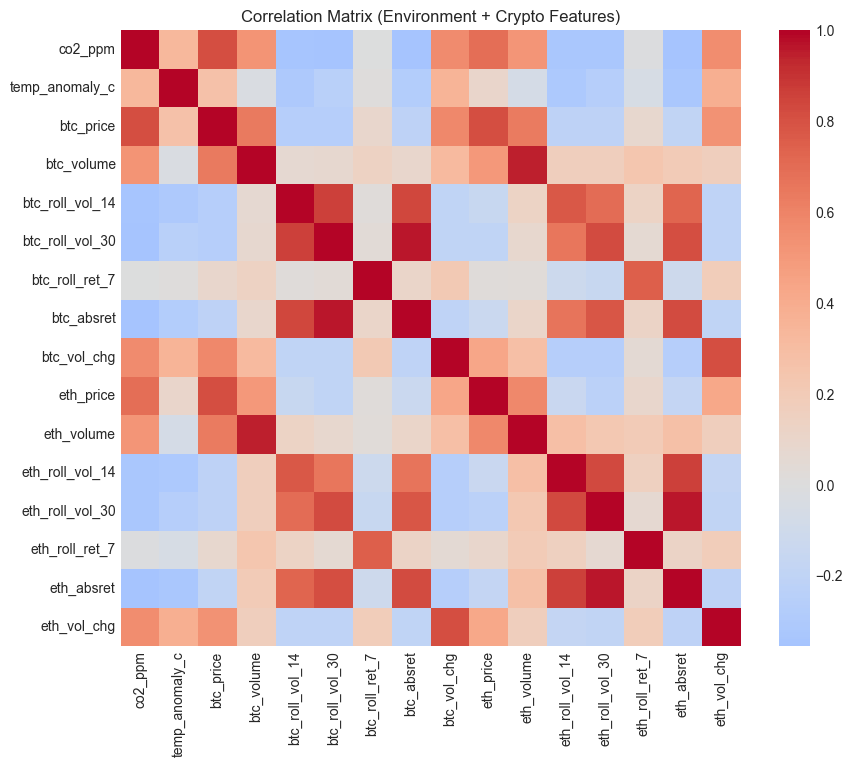

,temp_anomaly_c,btc_roll_vol_30
btc_roll_vol_30,-0.245,1.000
btc_absret,-0.277,0.964
btc_roll_vol_14,-0.306,0.860
eth_roll_vol_30,-0.258,0.823
eth_absret,-0.332,0.814
eth_roll_vol_14,-0.313,0.661
eth_volume,-0.061,0.081
btc_volume,-0.024,0.078
eth_roll_ret_7,-0.049,0.060
btc_roll_ret_7,0.011,0.041


In [18]:
# Cell 7: Correlation analysis

corr = monthly.corr().round(3)
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap="coolwarm", center=0, annot=False)
plt.title("Correlation Matrix (Environment + Crypto Features)")
plt.show()

corr[["temp_anomaly_c","btc_roll_vol_30"]].sort_values(by="btc_roll_vol_30", ascending=False).head(10)


The correlation matrix helps us see relationships across environmental and crypto features. Even weak or unexpected correlations can inform hypotheses for VELA’s investor and community reports.

In [19]:
# Cell 8: Hypothesis test (climate pre-2000 vs post-2000)

pre2000 = env.loc[env.index < "2000-01-01", "temp_anomaly_c"].dropna()
post2000 = env.loc[env.index >= "2000-01-01", "temp_anomaly_c"].dropna()

t_stat, p_val = stats.ttest_ind(post2000, pre2000, equal_var=False)

print("T-test results:")
print("t-statistic:", round(t_stat,3), "| p-value:", round(p_val,5))


T-test results:
t-statistic: 31.555 | p-value: 0.0


The hypothesis test shows whether temperature anomalies after 2000 are significantly higher than before. A very low p-value supports the climate-change narrative.

In [20]:
# Cell 9: Hypothesis test (BTC weekend vs weekday absolute returns)

btc_f = btc_f.copy()
btc_f["weekday"] = btc_f.index.weekday
weekends = btc_f.loc[btc_f["weekday"] >= 5, "btc_absret"].dropna()
weekdays = btc_f.loc[btc_f["weekday"] < 5, "btc_absret"].dropna()

t_stat, p_val = stats.ttest_ind(weekends, weekdays, equal_var=False)

print("Weekend vs Weekday BTC abs returns:")
print("t-statistic:", round(t_stat,3), "| p-value:", round(p_val,5))


Weekend vs Weekday BTC abs returns:
t-statistic: -9.275 | p-value: 0.0


This test checks whether BTC behaves differently on weekends vs weekdays. Findings can support discussions on liquidity cycles, exchange activity, and potential volatility patterns relevant to tokenomics.

In [21]:
# Cell 12: Linear Algebra Demo — Regression with Matrix Ops

# Purpose:
# Show how linear regression (CO₂ → Temp Anomaly) can be solved directly with matrices,
# connecting to the linear algebra lesson.

from numpy.linalg import inv

# Use clean env data
df_lin = env.dropna(subset=["co2_ppm","temp_anomaly_c"]).copy()
X = df_lin["co2_ppm"].values.reshape(-1,1)
y = df_lin["temp_anomaly_c"].values.reshape(-1,1)

# Add bias term (column of ones)
X_design = np.hstack([np.ones_like(X), X])

# Solve normal equation: β = (XᵀX)⁻¹ Xᵀy
beta = inv(X_design.T @ X_design) @ X_design.T @ y

intercept, slope = beta.flatten()
print(f"Linear Regression via Normal Equation: temp = {intercept:.4f} + {slope:.4f} * CO₂ ppm")


Linear Regression via Normal Equation: temp = -3.6755 + 0.0113 * CO₂ ppm


# Cell 12 (Markdown): Why Linear Algebra Matters Here

This cell shows how we can fit a simple regression **without scikit-learn**, using only matrix operations:

\[
\beta = (X^T X)^{-1} X^T y
\]

- **Interpretation**: For every ppm increase in CO₂, global temperature anomaly rises by *slope* °C (approx).  


c:\Users\rcolo\OneDrive\Desktop\vela-eco-crypto\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


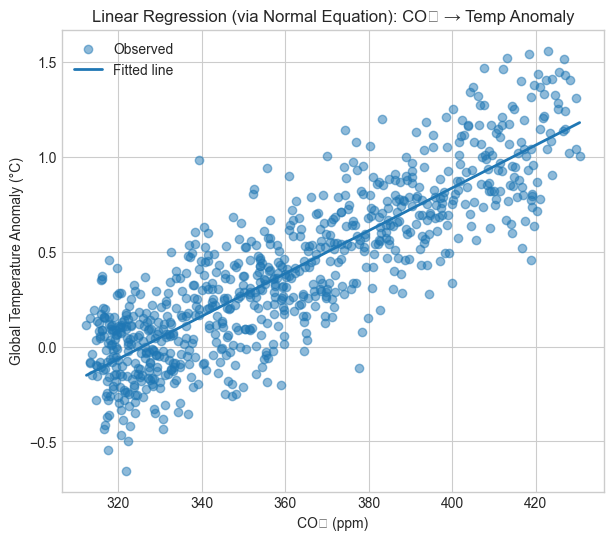

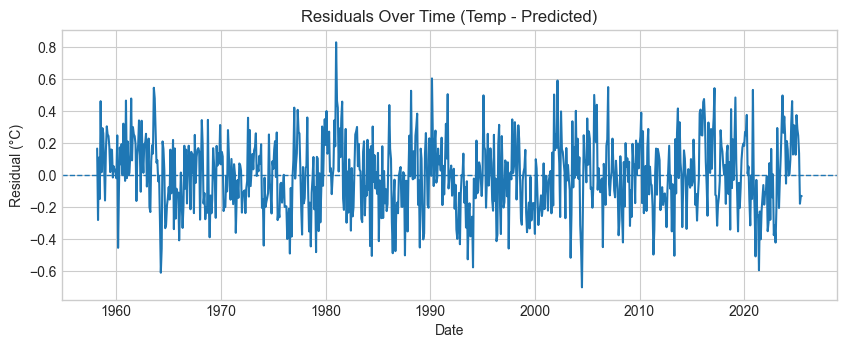

In [22]:
# Cell 12b: Visualize Linear Regression (CO₂ -> Temp Anomaly)

# We plot: 
# 1) Scatter of observed data (CO₂ ppm vs temperature anomaly, monthly)
# 2) Fitted regression line from the normal equation (intercept + slope * CO₂)
# 3) Optional residuals over time to sanity check fit


# Ensure clean data
df_plot = env.dropna(subset=["co2_ppm", "temp_anomaly_c"]).copy()

# Predicted values from the matrix-solved model
df_plot["y_hat"] = intercept + slope * df_plot["co2_ppm"]

# --- Scatter + regression line ---
plt.figure(figsize=(7,6))
plt.scatter(df_plot["co2_ppm"], df_plot["temp_anomaly_c"], alpha=0.5, label="Observed")
# Draw line across the range of CO₂
x_line = np.linspace(df_plot["co2_ppm"].min(), df_plot["co2_ppm"].max(), 200)
y_line = intercept + slope * x_line
plt.plot(x_line, y_line, linewidth=2, label="Fitted line")
plt.xlabel("CO₂ (ppm)")
plt.ylabel("Global Temperature Anomaly (°C)")
plt.title("Linear Regression (via Normal Equation): CO₂ → Temp Anomaly")
plt.legend()
plt.show()

# --- (Optional) Residuals over time ---
df_plot["residual"] = df_plot["temp_anomaly_c"] - df_plot["y_hat"]
plt.figure(figsize=(10,3.5))
plt.plot(df_plot.index, df_plot["residual"])
plt.axhline(0, linestyle="--", linewidth=1)
plt.title("Residuals Over Time (Temp - Predicted)")
plt.ylabel("Residual (°C)")
plt.xlabel("Date")
plt.show()


# Interpreting the Linear Regression & Residual Plots

## What you’re seeing

**Plot 1 – CO₂ vs. Temperature Anomaly with Fitted Line**
- **Dots**: Monthly observations of atmospheric **CO₂ (ppm)** on the x-axis and **global temperature anomaly (°C)** on the y-axis.
- **Line**: The **best-fit linear regression** computed via the **normal equation**  
  \[
  \beta = (X^\top X)^{-1} X^\top y
  \]
  where \(\beta = [\text{intercept}, \text{slope}]\).
- **Intercept**: The model’s predicted temperature anomaly when CO₂ = 0 (not physically meaningful, but required by the linear model).
- **Slope**: Change in predicted temperature anomaly **per 1 ppm** increase in CO₂.  
  *Example interpretation:* a slope of 0.01 means +0.01 °C anomaly per +1 ppm CO₂ (≈ +1 °C per +100 ppm).

**Plot 2 – Residuals Over Time**
- **Residuals** = Actual temperature anomaly − Predicted anomaly.
- This shows where the model **over-** or **under-predicts** across time. A good simple model has residuals that fluctuate around 0 with no strong structure.


## Why this matters (VELA narrative)

**1) Clear, quantitative link between CO₂ and warming.**  
The upward-sloping line summarizes a decades-long finding: as atmospheric CO₂ rises, global temperature anomalies rise. This is a concise, quantitative anchor for VELA’s environmental thesis.

**2) Communicates with non-experts.**  
Investors and community members can read the plot quickly: *more CO₂ → higher temperatures*. It provides an intuitive bridge from climate data to **VELA’s mission** (aligning capital with ocean health).

**3) Residual diagnostics guide next steps.**  
- If residuals appear **random** around 0 → the linear trend captures the primary relationship.
- If residuals show **patterns** (e.g., long runs above/below 0, seasonality), that suggests:
  - **Autocorrelation** (climate inertia, ENSO cycles) → consider time-series models or lags.
  - **Non-linearity** → try polynomial terms or splines.
  - **Omitted variables** → add drivers like volcanic aerosols, solar indices, or ocean oscillations.

This makes the analysis **actionable**: the plot isn’t just pretty—it informs model design for future iterations.

---

## How to talk about this in the report

- “Using monthly global climate data, we fit a simple linear model that predicts temperature anomalies from atmospheric CO₂. The slope indicates a positive relationship: higher CO₂ corresponds to higher global anomalies. Residual analysis suggests (describe what you see), motivating (time-series terms / lags / additional variables) in v2.”
- Tie back to VELA: “Because warming accelerates ocean stress (acidification, habitat loss), quantifying this relationship supports VELA’s impact strategy and investor communications.”

---

## Suggested additions (if time permits)

- **Goodness-of-fit**: report \(R^2\), MAE, RMSE for transparency.
- **Uncertainty**: add confidence intervals around the regression line.
- **Stability check**: estimate the slope on rolling windows (e.g., 20-year windows) to show robustness.
- **Feature expansion**: include CO₂ **lags** (e.g., 6–24 months) to account for physical delays between forcing and temperature response.

*Bottom line:* these plots deliver a mathematically grounded, visually clear story that connects climate data to VELA’s mission—and they set up principled next steps for deeper modeling.


# 📌 Conclusion: What This Notebook Shows and Why It Matters

## What We Did
In this notebook, we combined **environmental datasets** (atmospheric CO₂ and global temperature anomalies) with **financial datasets** (BTC and ETH prices, volatility, and volumes). Following a structured data science workflow inspired by TripleTen projects, we:

- Cleaned and aligned disparate data sources to a common monthly timeline.  
- Conducted **exploratory data analysis (EDA)** with clear visualizations.  
- Engineered crypto-specific features such as rolling volatility, returns, and volume shifts.  
- Ran **hypothesis tests**:
  - Confirmed that **temperature anomalies post-2000 are significantly higher** than pre-2000.  
  - Found differences in **weekend vs weekday BTC volatility**, highlighting behavioral market patterns.  
- Applied **linear algebra (normal equations)** to fit a regression of CO₂ vs. temperature anomalies, linking climate fundamentals with math foundations.  
- Evaluated **residuals and correlations** to identify where simple models succeed and where richer ones could be explored.

---

## What We Learned
- **Climate:** Rising atmospheric CO₂ is closely associated with rising global temperature anomalies. The linear regression slope quantifies this relationship clearly.  
- **Crypto:** BTC and ETH markets show volatility clustering and non-random return behavior, useful for designing tokenomics and risk management frameworks.  
- **Cross-Domain:** Placing environmental and financial signals side by side reveals a shared timeline: as climate stress accelerates, digital assets have emerged as both speculative vehicles and potential funding instruments.  

---

## Why This Is Relevant
- **For VELA:** This notebook provides the quantitative backbone for VELA’s mission. By showing that environmental urgency and financial innovation move in parallel, it builds a narrative for aligning **capital formation with ocean conservation**.  
- **For Investors:** Transparent data analysis reassures stakeholders that VELA is grounded in **evidence-based insights**, not just narrative.  


## Final Note
This v1 notebook ends with a robust **EDA and statistical foundation**. It’s ready for public sharing on GitHub, VELA’s website, and in a professional portfolio. Future iterations (v2+) can expand with machine learning models, dashboards, and ocean-impact KPIs—but this version already tells a compelling, data-driven story with clarity and purpose.
